# Inititial processing

In [80]:
!pip install ecoindex
!pip install SQLAlchemy 
!pip install shap
!pip install tornado==4.5.3
!pip install bayesian_optimization


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Using cached ecoindex-5.0.0-py3-none-any.whl (5.1 kB)
  Using cached sqlmodel-0.0.7-py3-none-any.whl (21 kB)
  Using cached sqlalchemy2_stubs-0.0.2a29-py3-none-any.whl (191 kB)
  Using cached SQLAlchemy-1.4.41-cp38-cp38-manylinux_2_5_x86_64.manylinux1_x86_64.manylinux_2_17_x86_64.manylinux2014_x86_64.whl (1.6 MB)
  Attempting uninstall: SQLAlchemy
    Found existing installation: SQLAlchemy 1.4.44
    Uninstalling SQLAlchemy-1.4.44:
      Successfully uninstalled SQLAlchemy-1.4.44
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import asyncio
from pprint import pprint
from ecoindex import get_ecoindex
from ecoindex.quantiles import quantiles_dom, quantiles_req, quantiles_size
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression, Ridge, Lasso
from sklearn.metrics import precision_score, recall_score, accuracy_score, f1_score, confusion_matrix, ConfusionMatrixDisplay, roc_curve, roc_auc_score
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import precision_recall_fscore_support, confusion_matrix,ConfusionMatrixDisplay
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import GradientBoostingRegressor
import time
import shap
from xgboost import XGBClassifier
from sklearn.ensemble import HistGradientBoostingClassifier 
from sklearn.ensemble import HistGradientBoostingRegressor
from pandas.io.formats.format import DataFrameRenderer
from sklearn.feature_selection import RFE
from bayes_opt import BayesianOptimization


In [81]:
#Useful function if we want to display a specific number of row and columns
#Set to None if you want to display all 

pd.set_option('display.max_rows',10)
pd.set_option('display.max_columns',None)

In [90]:
df = pd.read_csv('data_eco_Index.csv')
df = df.drop(labels = 'Unnamed: 0', axis = 1)
#save a copy
df_old = df
df

,urlName,domSize,nbRequest,responsesSize,ecoIndex,grade,performance,accessibility,largestContentfulPaint,cumulativeLayoutShift,firstContentfulPaint,speedIndex,totalBlockingTime,interactive,addExpiresOrCacheControlHeaders,compressHttp,domainsNumber,dontResizeImageInBrowser,emptySrcTag,externalizeCss,externalizeJs,httpError,httpRequests,imageDownloadedNotDisplayed,jsValidate,maxCookiesLength,minifiedCss,minifiedJs,noCookieForStaticRessources,noRedirect,optimizeBitmapImages,optimizeSvg,plugins,printStyleSheet,socialNetworkButton,styleSheets,useETags,useStandardTypefaces,viewport,serverResponseTime,criticalRequestChains,mainthreadWorkBreakdown,bootupTime,usesRelPreload,fontDisplay,networkRtt,networkServerLatency,thirdPartySummary,thirdPartyFacades,lcpLazyLoaded,longTasks,nonCompositedAnimations,preloadLcpImage,usesLongCacheTtl,usesResponsiveImages,offscreenImages,unminifiedCss,unminifiedJavascript,unusedCssRules,unusedJavascript,usesOptimizedImages,modernImageFormats,usesTextCompression,usesHttp2,efficientAnimatedContent,duplicatedJavascript,legacyJavascript,totalByteWeight,noDocumentWrite,redirects,layoutShiftElements,usesPassiveEventListeners
0,https://colab.research.google.com/?utm_source=...,19.0,66,3124,36,E,15,91,0,100,0,0,0,0,50,75,0,20,100,0,0,0,35,100,0,100,0,35,100,100,100,100,100,0,100,20,0,0,100,100,0,0.0,2.0,0,0,0,0,0,0,100,0,0,100,6.0,100.0,100.0,100.0,100.0,75.0,0.0,100.0,100.0,100.0,100.0,100.0,100.0,88.0,87.0,100,100.0,0,100
1,http://localhost:3001/,100.0,32,1734,73,B,27,92,6,100,66,30,2,7,0,75,0,100,100,75,100,100,65,100,0,100,100,0,100,75,100,100,100,0,100,75,0,0,100,100,0,80.0,89.0,0,100,0,0,100,0,0,0,0,100,7.0,100.0,100.0,100.0,43.0,88.0,34.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100,100.0,0,100
2,http://www.aboutus.org,100.0,89,1287,57,C,46,77,76,100,47,27,10,14,0,35,0,35,100,50,0,100,20,100,0,100,0,0,100,0,100,100,100,0,100,35,0,0,0,100,0,100.0,100.0,0,100,0,0,0,0,0,0,0,0,64.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,79.0,100.0,100.0,100.0,100.0,100.0,100.0,100,100.0,0,100
3,http://above-inc.com,100.0,3,84,92,A,0,63,0,100,96,100,100,100,0,0,100,100,100,75,100,100,100,100,100,100,0,0,100,75,100,100,100,0,100,100,100,100,100,0,0,13.0,36.0,0,0,0,0,0,0,0,0,0,100,34.0,100.0,100.0,100.0,100.0,88.0,40.0,100.0,88.0,50.0,100.0,70.0,100.0,100.0,100.0,0,100.0,0,100
4,http://www.abpathfinder.com,57.0,120,1800,16,F,15,85,2,70,5,9,8,6,50,75,0,20,100,0,0,100,20,50,0,100,0,35,100,0,100,100,100,0,100,0,0,0,100,100,0,8.0,32.0,0,0,0,0,0,0,100,0,0,100,40.0,78.0,82.0,100.0,100.0,49.0,36.0,100.0,44.0,100.0,100.0,100.0,100.0,100.0,100.0,100,31.0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
550,https://www.amazon.com/,40.0,366,3534,10,G,57,94,69,86,51,7,66,23,75,75,0,0,100,0,0,0,0,50,50,100,100,100,100,0,0,100,100,0,100,50,0,0,100,100,0,0.0,76.0,0,100,0,0,100,0,0,0,0,100,7.0,83.0,0.0,100.0,83.0,47.0,17.0,69.0,0.0,45.0,100.0,100.0,100.0,83.0,2.0,0,100.0,0,0
551,https://www.accenture.com/us-en,68.0,85,6666,23,F,34,98,1,96,3,0,62,0,75,50,50,0,100,0,0,100,35,25,0,100,0,0,100,75,0,100,100,0,100,35,75,100,100,100,0,11.0,63.0,0,0,0,0,0,0,100,0,0,100,99.0,48.0,100.0,100.0,100.0,100.0,41.0,88.0,41.0,88.0,100.0,100.0,100.0,100.0,99.0,0,100.0,0,0
552,https://ts-rhsso.tmma.paris.mdp/recrutement-is...,100.0,51,1018,67,C,49,98,0,99,0,0,100,41,0,0,75,100,100,100,0,50,35,100,0,100,0,0,100,75,100,100,100,0,100,20,75,0,100,0,0,75.0,100.0,0,0,0,0,0,0,0,0,0,0,7.0,100.0,100.0,100.0,100.0,88.0,88.0,100.0,100.0,88.0,0.0,100.0,100.0,100.0,100.0,100,100.0,0,100
553,https://ts-rhsso.tmma.paris.mdp/recrutement-is...,97.0,58,979,58,C,49,93,0,99,20,9,100,11,0,0,75,100,100,100,0,0,35,100,0,100,0,0,100,75,100,100,100,0,100,0,75,0,100,100,0,76.0,100.0,0,0,0,0,0,0,0,0,0,0,6.0,100.0,100.0,100.0,100.0,75.0,67

## Visualisation

In [86]:
df.describe()

,domSize,nbRequest,responsesSize,ecoIndex,addExpiresOrCacheControlHeaders,compressHttp,domainsNumber,dontResizeImageInBrowser,emptySrcTag,externalizeCss,externalizeJs,httpError,httpRequests,imageDownloadedNotDisplayed,jsValidate,maxCookiesLength,minifiedCss,minifiedJs,noCookieForStaticRessources,noRedirect,optimizeBitmapImages,optimizeSvg,plugins,printStyleSheet,socialNetworkButton,styleSheets,useETags,useStandardTypefaces,viewport,serverResponseTime,criticalRequestChains,mainthreadWorkBreakdown,bootupTime,usesRelPreload,fontDisplay,networkRtt,networkServerLatency,thirdPartySummary,thirdPartyFacades,lcpLazyLoaded,longTasks,nonCompositedAnimations,preloadLcpImage,usesLongCacheTtl,usesResponsiveImages,offscreenImages,unminifiedCss,unminifiedJavascript,unusedCssRules,unusedJavascript,usesOptimizedImages,modernImageFormats,usesTextCompression,usesHttp2,efficientAnimatedContent,duplicatedJavascript,legacyJavascript,totalByteWeight,noDocumentWrite,redirects,layoutShiftElements,usesPassiveEventListeners
count,555.000000,555.000000,555.000000,555.000000,555.000000,555.000000,555.000000,555.000000,555.000000,555.000000,555.000000,555.000000,555.000000,555.000000,555.000000,555.0,555.000000,555.000000,555.0,555.000000,555.000000,555.000000,555.000000,555.000000,555.000000,555.000000,555.000000,555.000000,555.000000,555.000000,555.0,555.000000,555.000000,555.0,555.000000,555.0,555.0,555.000000,555.0,555.000000,555.0,555.0,555.000000,555.000000,555.000000,555.000000,555.000000,555.000000,555.000000,555.000000,555.000000,555.000000,555.000000,555.000000,555.000000,555.000000,555.000000,555.000000,555.000000,555.000000,555.0,555.000000
mean,67.306306,74.772973,2360.969369,48.596396,40.171171,63.396396,32.954955,38.369369,96.036036,38.810811,20.630631,82.792793,45.072072,74.189189,5.765766,100.0,14.846847,23.585586,100.0,60.747748,96.396396,88.036036,98.918919,5.045045,93.594595,48.855856,18.738739,34.864865,74.774775,67.747748,0.0,45.194595,62.848649,0.0,36.756757,0.0,0.0,39.099099,0.0,49.009009,0.0,0.0,82.421622,38.187387,69.864865,74.313514,86.445045,82.877477,68.731532,44.075676,71.789189,49.767568,80.145946,76.198198,87.084685,87.571171,85.796396,71.931532,66.306306,80.645045,0.0,53.873874
std,40.139421,69.734973,3706.465784,27.043140,40.612609,25.279049,39.333432,43.928258,19.528711,41.449703,35.515271,32.859266,30.057019,34.636721,21.095859,0.0,34.485962,38.416647,0.0,38.411948,17.914397,30.021331,10.350478,21.907002,20.094712,38.295084,34.223388,47.460127,43.469705,46.786339,0.0,40.167137,37.236615,0.0,48.257772,0.0,0.0,48.841258,0.0,50.035276,0.0,0.0,36.848978,36.943476,40.198444,38.239494,32.270995,33.526154,33.845876,33.562185,39.697874,40.915803,36.140000,37.170118,32.983450,32.246678,32.211395,40.935306,47.308953,36.259670,0.0,49.894676
min,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,100.0,0.000000,0.000000,100.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000
25%,25.000000,23.000000,445.000000,25.500000,0.000000,75.000000,0.000000,0.000000,100.000000,0.000000,0.000000,100.000000,20.000000,50.000000,0.000000,100.0,0.000000,0.000000,100.0,35.000000,100.000000,100.000000,100.000000,0.000000,100.000000,10.000000,0.000000,0.000000,0.000000,0.000000,0.0,4.000000,31.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,100.000000,2.500000,40.000000,47.000000,100.000000,87.500000,48.000000,17.500000,45.000000,0.000000,79.500000,51.000000,100.000000,100.000000,97.500000,32.000000,0.000000,100.000000,0.0,0.000000
50%,93.000000,59.000000,1351.000000,47.000000,35.000000,75.000000,0.000000,20.000000,100.000000,20.000000,0.000000,100.000000,35.000000,100.

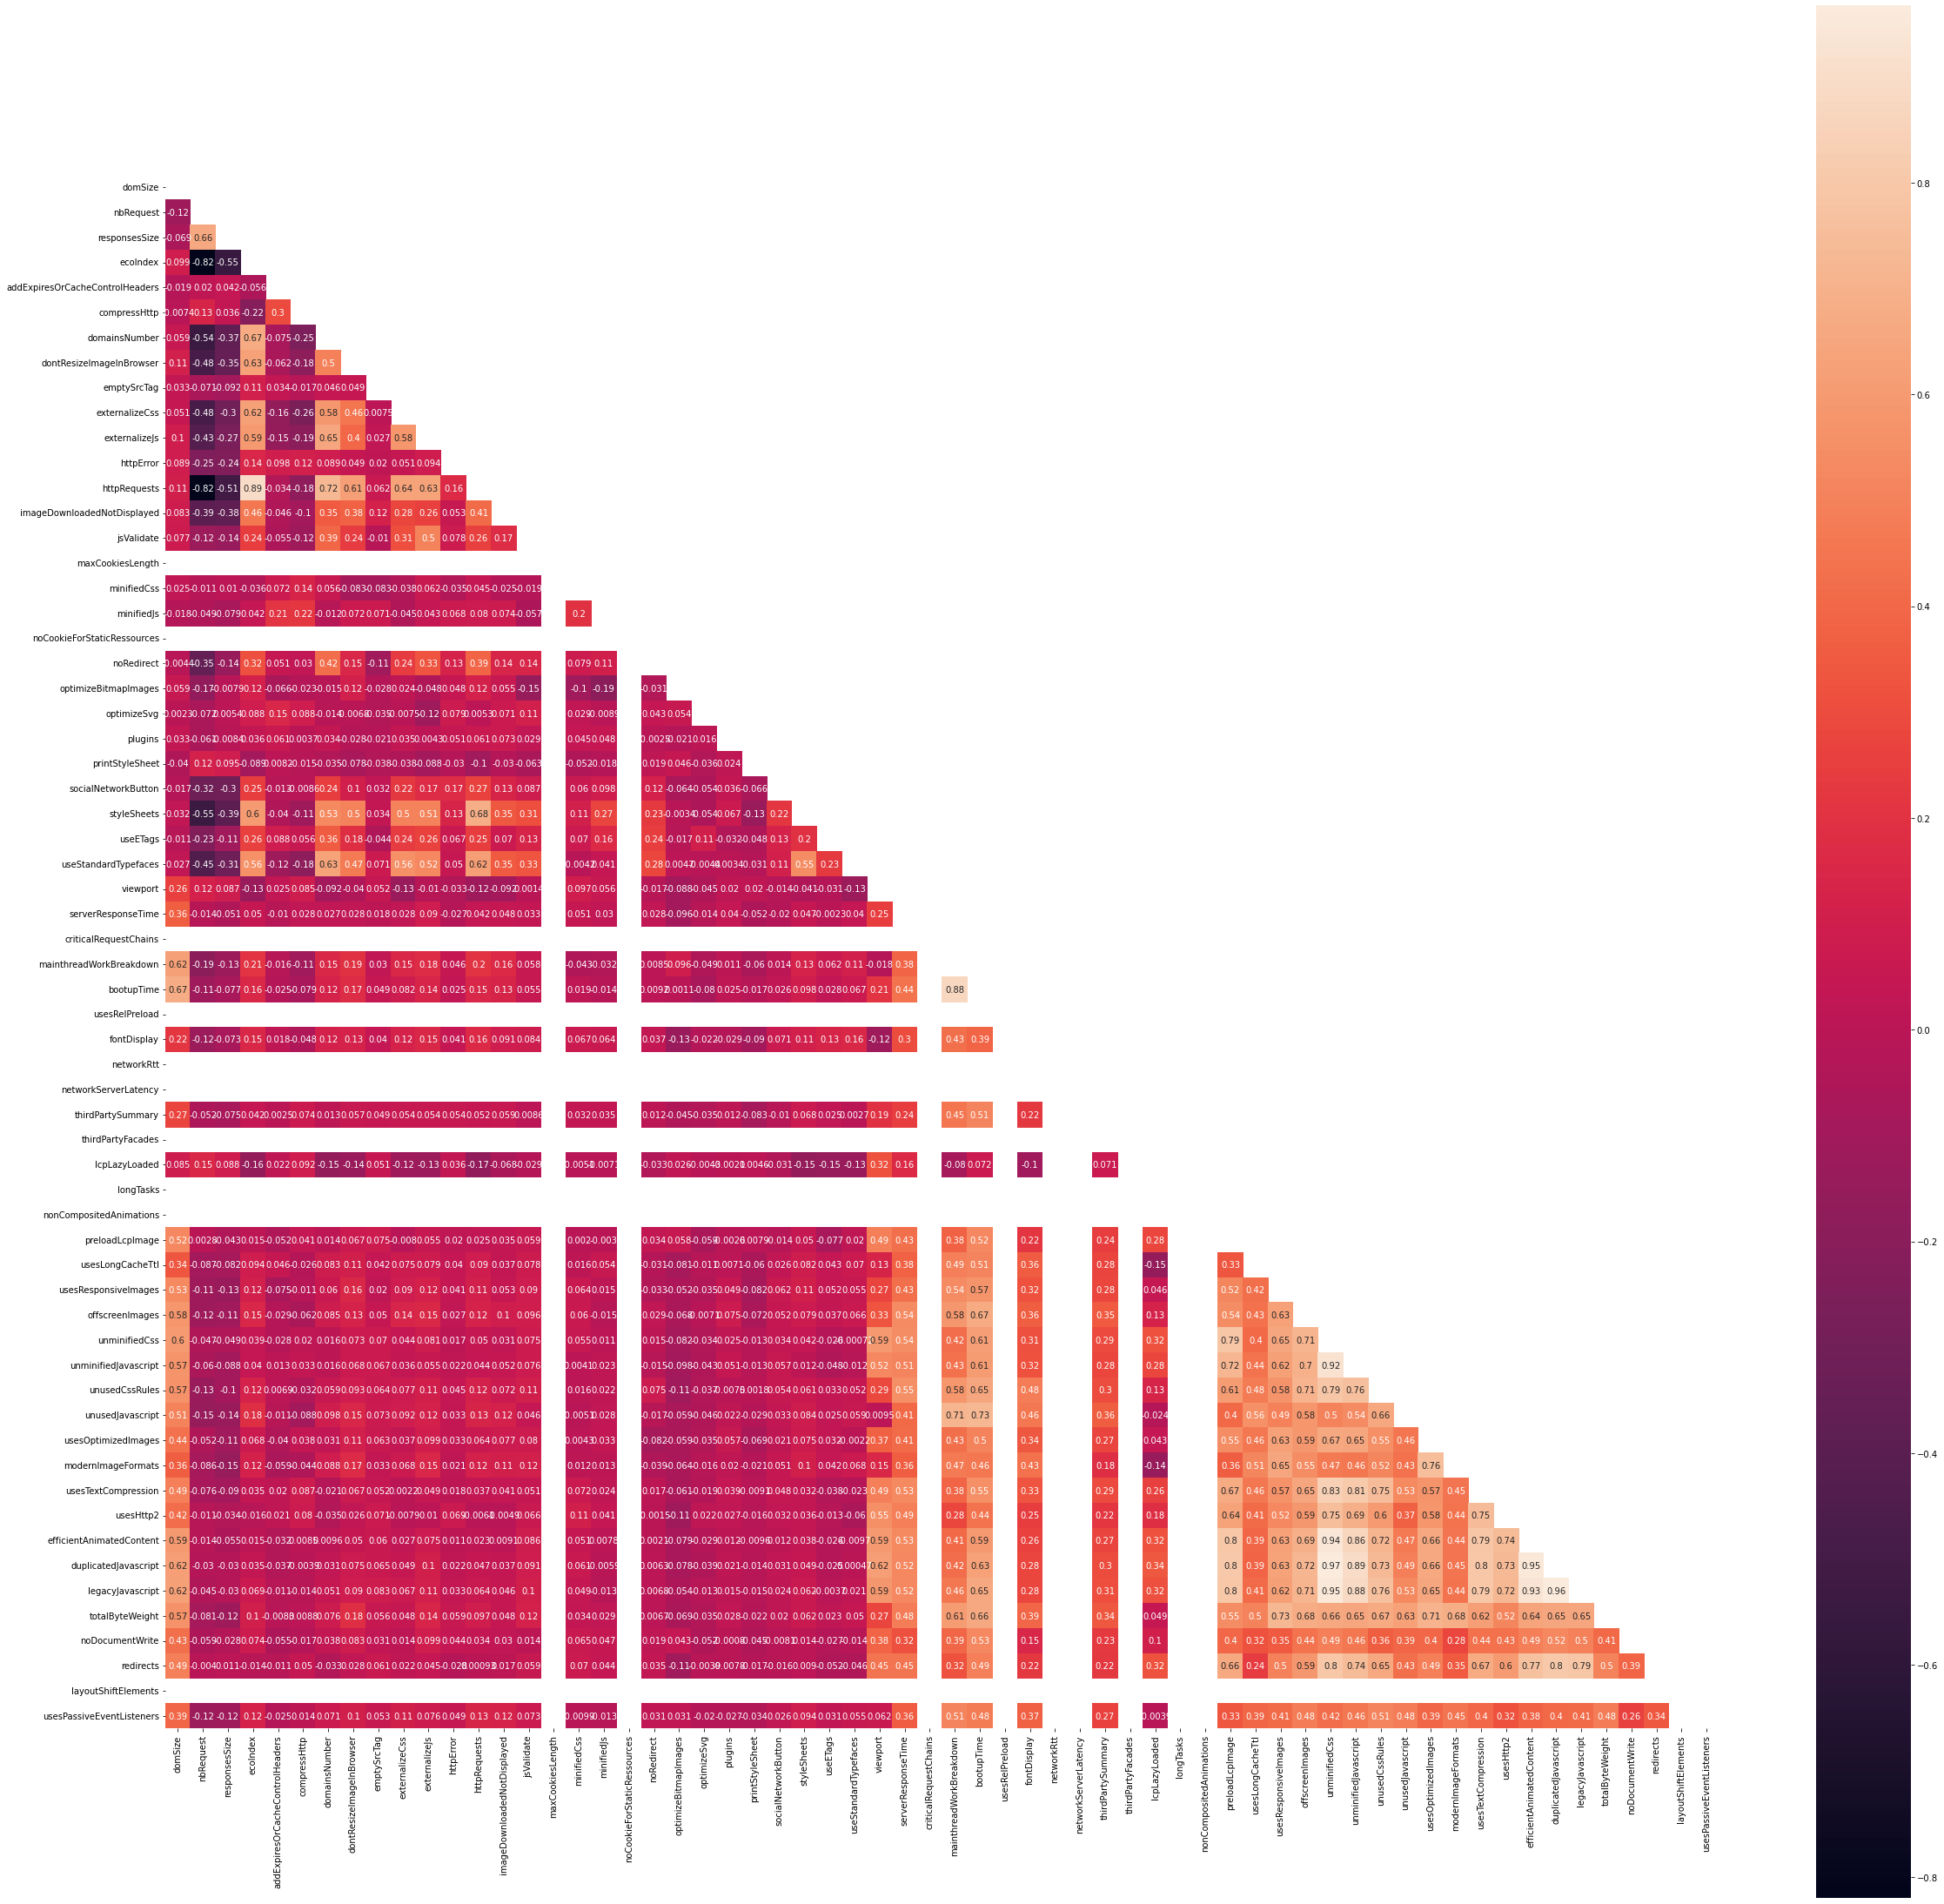

In [87]:
#This is the correlation matrix to display the correlation coefficient for the different variables

#pearson is the standard correlation coefficient
correlation = df.corr(method = 'pearson')

#plot the figure
plt.subplots(figsize = (40,40))

#mask upper triangle
masked = np.triu(np.ones_like(correlation, dtype=bool)) 

#correlation matrix with the coefficient
sns.heatmap(correlation,mask=masked,square = True, annot = True)

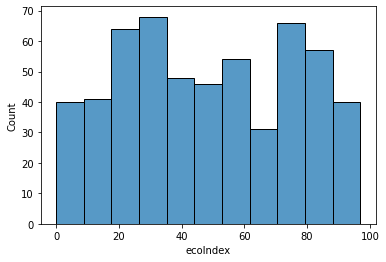

In [88]:
%matplotlib inline

sns.histplot(data=df, x='ecoIndex')


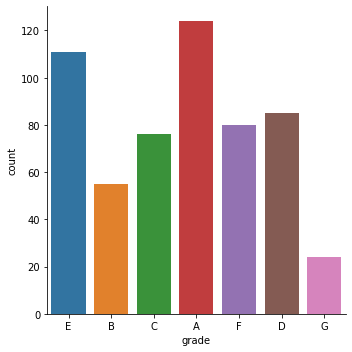

In [92]:
sns.catplot(x = 'grade', kind = 'count', data = df)

plt.show()

# EcoIndex Formulas

In [93]:
def get_quantile(quantiles, value):
   
    for i in range(1, len(quantiles) + 1):
        if value < quantiles[i]:
            return (i - 1 + (value - quantiles[i - 1]) / (quantiles[i] - quantiles[i - 1]))

    return len(quantiles) - 1
  


In [94]:
def get_score(dom: int, size: float, requests: int):
    q_dom = get_quantile(quantiles_dom, dom)
    q_size = get_quantile(quantiles_size, size)
    q_req = get_quantile(quantiles_req, requests)

    return round(100 - 5 * (3 * q_dom + 2 * q_req + q_size) / 6)


In [96]:
#Example
#get_score(dom= 80, size= 8, requests= 1)


## Other Useful formulas

In [97]:
#Fucntion to get the most important features

def get_feature_importance(importance_metric, X_train_number):

    feat = pd.Series(importance_metric*100, index=X_train_number.columns)
    feat_s = feat.sort_values(axis=0, ascending=False)
    feat = feat_s.index.tolist()
    
    features = []
    for values in feat:
        if feat_s[values] > 1 :
            features.append(values)
            
    
    return features

# EcoIndex

In [111]:
#we dropped the intermediate columns (performance --> Interactive since it is a grade metric and not recommendations)
df1 = df.iloc[:, 0:5]

df2 =  df.iloc[:, 14:]

df = pd.concat([df1, df2], axis = 1)

In [43]:
X = df.drop(columns = ["ecoIndex", 'nbRequest',	'responsesSize','domSize', 'httpRequests', 'urlName', "grade"])
y = df["ecoIndex"]


# split the data into developing and testing sets
X_dev,X_test,y_dev,y_test = train_test_split(X,y,test_size=0.2,random_state=42)


X_train,X_val,y_train,y_val = train_test_split(X_dev,y_dev,test_size=0.2,random_state=42)

In [59]:
#save a copy
X_dev_ecoIndex = X_test
y_test_ecoIndex = y_test

## Random Forest

In [275]:
params = {'n_estimators' : [10,50, 100, 200],
          'max_depth' : [10, 20, 40,50]}


rf = RandomForestRegressor(random_state=42)

gs1 = GridSearchCV(rf, params, cv = 5)

gs1.fit(X_train, y_train)


y_pred = gs1.predict(X_test)

print ('Best Parameters: ', gs1.best_params_, ' \n')

print("results before feature selection:")
print(f'model score on training data : {gs1.score(X_dev,  y_dev)}')
print(f'model score on testing data: {gs1.score(X_test, y_test)}')

importances_eco_index = gs1.best_estimator_.feature_importances_

model_EcoIndex = gs1 

Best Parameters:  {'max_depth': 40, 'n_estimators': 200}  

results before feature selection:
model score on training data : 0.9036769095415425
model score on testing data: 0.7115220369029887


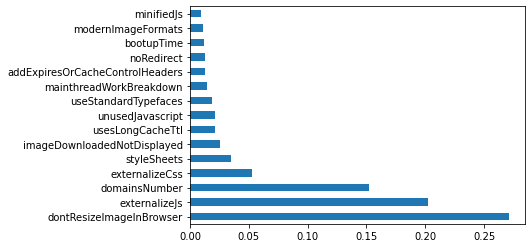

In [276]:
pd.Series(importances_eco_index, index=X_train.columns).nlargest(15).plot(kind='barh') 


In [277]:
importances_eco_index = get_feature_importance(importances_eco_index, X_train)

['dontResizeImageInBrowser',
 'externalizeJs',
 'domainsNumber',
 'externalizeCss',
 'styleSheets',
 'imageDownloadedNotDisplayed',
 'usesLongCacheTtl',
 'unusedJavascript',
 'useStandardTypefaces',
 'mainthreadWorkBreakdown',
 'addExpiresOrCacheControlHeaders',
 'noRedirect',
 'bootupTime',
 'modernImageFormats']

Permutation explainer: 112it [01:07,  1.40it/s]


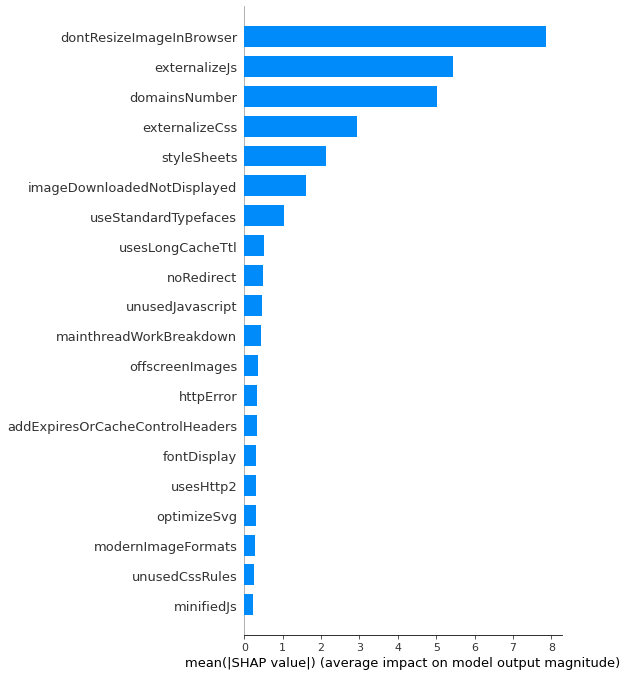

In [278]:
explainer = shap.Explainer(gs1.predict, X_test)

shap_values = explainer(X_test)

shap.summary_plot(shap_values, features=X, feature_names=X.columns, plot_type='bar')

In [164]:
X_test

,addExpiresOrCacheControlHeaders,compressHttp,domainsNumber,dontResizeImageInBrowser,emptySrcTag,externalizeCss,externalizeJs,httpError,imageDownloadedNotDisplayed,jsValidate,maxCookiesLength,minifiedCss,minifiedJs,noCookieForStaticRessources,noRedirect,optimizeBitmapImages,optimizeSvg,plugins,printStyleSheet,socialNetworkButton,styleSheets,useETags,useStandardTypefaces,viewport,serverResponseTime,criticalRequestChains,mainthreadWorkBreakdown,bootupTime,usesRelPreload,fontDisplay,networkRtt,networkServerLatency,thirdPartySummary,thirdPartyFacades,lcpLazyLoaded,longTasks,nonCompositedAnimations,preloadLcpImage,usesLongCacheTtl,usesResponsiveImages,offscreenImages,unminifiedCss,unminifiedJavascript,unusedCssRules,unusedJavascript,usesOptimizedImages,modernImageFormats,usesTextCompression,usesHttp2,efficientAnimatedContent,duplicatedJavascript,legacyJavascript,totalByteWeight,noDocumentWrite,redirects,layoutShiftElements,usesPassiveEventListeners
231,35,75,0,0,100,0,0,100,25,0,100,0,0,100,0,100,100,100,0,100,35,0,0,0,0,0,0.0,0.0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0,0
374,20,75,0,0,100,0,0,100,100,0,100,0,0,100,100,100,100,100,0,100,50,0,0,100,100,0,63.0,82.0,0,100,0,0,100,0,100,0,0,100,54.0,100.0,100.0,100.0,100.0,91.0,47.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100,100.0,0,0
55,0,75,0,100,100,0,0,100,100,0,100,0,0,100,100,100,0,0,0,100,0,0,0,100,0,0,22.0,49.0,0,100,0,0,0,0,0,0,0,100,30.0,32.0,40.0,100.0,100.0,100.0,0.0,100.0,87.0,100.0,100.0,100.0,100.0,87.0,74.0,100,100.0,0,100
381,0,35,20,20,100,75,0,100,100,0,100,0,0,100,75,100,100,100,0,100,100,0,100,0,100,0,100.0,100.0,0,100,0,0,0,0,100,0,0,100,2.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,0.0,100.0,44.0,100.0,100.0,100.0,100.0,100,100.0,0,100
70,0,75,0,100,100,100,0,50,100,0,100,0,35,100,0,100,0,100,0,100,65,0,0,100,100,0,92.0,97.0,0,0,0,0,100,0,0,0,0,100,47.0,100.0,100.0,100.0,100.0,86.0,46.0,74.0,48.0,100.0,100.0,100.0,100.0,100.0,100.0,100,100.0,0,100
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11,0,75,0,0,100,20,0,100,50,0,100,0,20,100,0,100,100,100,0,100,75,0,0,100,100,0,100.0,99.0,0,100,0,0,100,0,0,0,0,100,100.0,100.0,100.0,100.0,100.0,100.0,46.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100,100.0,0,100
281,100,75,35,0,100,0,0,100,50,0,100,0,0,100,35,100,100,100,0,100,0,0,0,100,0,0,69.0,98.0,0,100,0,0,100,0,0,0,0,100,23.0,100.0,100.0,100.0,100.0,40.0,53.0,26.0,0.0,81.0,100.0,100.0,100.0,100.0,84.0,100,100.0,0,0
22,100,75,75,100,100,100,50,100,100,0,100,0,100,100,100,100,100,100,0,100,100,100,100,100,100,0,99.0,98.0,0,100,0,0,100,0,100,0,0,100,66.0,100.0,100.0,100.0,100.0,100.0,67.0,100.0,64.0,100.0,74.0,100.0,100.0,100.0,100.0,0,100.0,0,100
375,0,75,100,0,100,100,75,100,100,0,100,0,0,100,75,100,100,100,0,100,35,100,0,0,100,0,100.0,99.0,0,100,0,0,100,0,0,0,0,100,93.0,100.0,100.0,100.0,100.0,100.0,63.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100,100.0,0,100


## XGB

In [45]:

start_time = time.time()

params = {'min_samples_split' : [2,10,50],
          'learning_rate' : [0.1,0.002],
          'n_estimators' : [20, 40, 70]}

gs2 = GridSearchCV(GradientBoostingRegressor(), params, cv = 5)

gs2.fit(X_dev, y_dev)

print("Time: {} seconds".format(time.time() - start_time))

print("best parameters are", gs2.best_params_)

print("model performance on test dataset", gs2.score(X_test, y_test))

y_pred = gs2.predict(X_test)


print("results before feature selection:")
print(f'model score on training data : {gs2.score(X_dev,  y_dev)}')
print(f'model score on testing data: {gs2.score(X_test, y_test)}')

importances_eco_index = gs2.best_estimator_.feature_importances_

model_EcoIndex = gs2


Time: 5.900673866271973 seconds
best parameters are {'learning_rate': 0.1, 'min_samples_split': 10, 'n_estimators': 40}
model performance on test dataset 0.767739772049372
results before feature selection:
model score on training data : 0.8238251018774313
model score on testing data: 0.767739772049372


In [46]:
##Bayesian Optimization


param_bounds = {
    'min_samples_split': (2, 10),  
    'learning_rate': (0.01, 0.1),  
    'n_estimators': (20, 70),      
}


def objective(min_samples_split, learning_rate, n_estimators):
    model = GradientBoostingRegressor(
        min_samples_split=int(min_samples_split),
        learning_rate=learning_rate,
        n_estimators=int(n_estimators),
    )
    model.fit(X_dev, y_dev)
    return model.score(X_test, y_test)


bo = BayesianOptimization(objective, param_bounds)


bo.maximize(n_iter=10)


print(f"Best hyperparameters: {bo.max['params']}")
print(f"Best performance: {bo.max['target']}")


best_params = bo.max['params']
final_model = GradientBoostingRegressor(
    min_samples_split=int(best_params['min_samples_split']),
    learning_rate=best_params['learning_rate'],
    n_estimators=int(best_params['n_estimators']),
)
final_model.fit(X_train, y_train)


|   iter    |  target   | learni... | min_sa... | n_esti... |
-------------------------------------------------------------
| 1         | 0.7623    | 0.07476   | 7.441     | 56.19     |
| 2         | 0.7017    | 0.03496   | 6.516     | 56.62     |
| 3         | 0.7323    | 0.08998   | 3.378     | 28.11     |
| 4         | 0.3607    | 0.01736   | 6.667     | 25.58     |
| 5         | 0.6039    | 0.02343   | 8.664     | 49.66     |
| 6         | 0.7749    | 0.1       | 9.654     | 57.15     |
| 7         | 0.7779    | 0.1       | 10.0      | 54.27     |
| 8         | 0.7552    | 0.1       | 2.0       | 31.86     |
| 9         | 0.7683    | 0.1       | 5.314     | 35.9      |
| 10        | 0.7713    | 0.1       | 2.0       | 38.66     |
| 11        | 0.34      | 0.01      | 6.222     | 40.4      |
| 12        | 0.3083    | 0.01      | 2.0       | 35.46     |
| 13        | 0.6831    | 0.03127   | 9.154     | 55.66     |
| 14        | 0.7753    | 0.1       | 8.184     | 58.09     |
| 15    

GradientBoostingRegressor(min_samples_split=10, n_estimators=54)

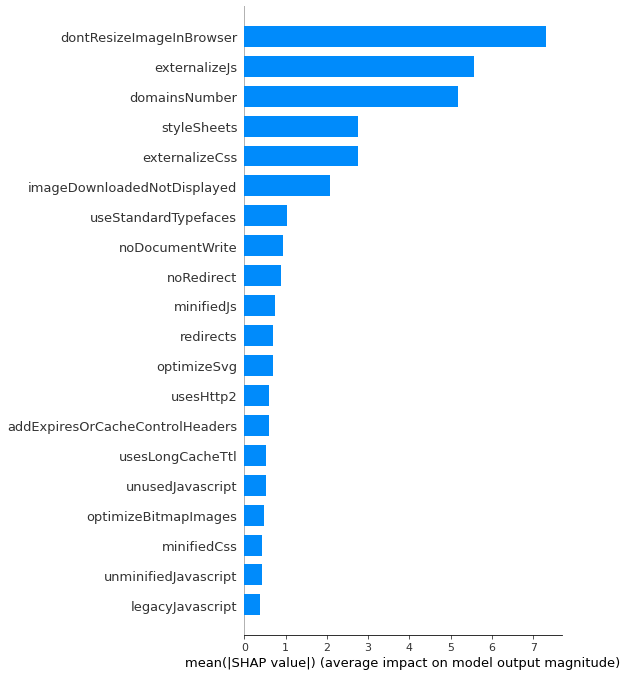

In [167]:
explainer = shap.Explainer(final_model.predict, X_test)

shap_values = explainer(X_test)

shap.summary_plot(shap_values, features=X, feature_names=X.columns, plot_type='bar')

In [169]:
shap.initjs()

random_index = 15
 
 
shap.plots.force(shap_values[random_index])


# Regression

## Nb Request

In [117]:
X = df.drop(columns = ["ecoIndex",	'nbRequest',	'responsesSize','domSize', 'httpRequests','urlName' ])
y = df["nbRequest"]


# split the data into developing and testing sets
X_dev,X_test,y_dev,y_test = train_test_split(X,y,test_size=0.2,random_state=42)


### Random Forest

In [118]:
start_time = time.time()

params = {'n_estimators' : [10,50, 100, 200],
          'max_depth' : [10, 20, 40,50]}


rf = RandomForestRegressor(random_state=42)

gs1 = GridSearchCV(rf, params, cv = 5)

gs1.fit(X_dev, y_dev)

print("Time: {} seconds".format(time.time() - start_time))

y_pred = gs1.predict(X_test)

print ('Best Parameters: ', gs1.best_params_, ' \n')

print("results before feature selection:")
print(f'model score on training data : {gs1.score(X_dev,  y_dev)}')
print(f'model score on testing data: {gs1.score(X_test, y_test)}')

importances_nbRequest = gs1.best_estimator_.feature_importances_


best_model = RandomForestRegressor(**gs1.best_params_)


rfe = RFE(best_model, n_features_to_select=15)

# Fit the model to the data
rfe.fit(X_dev, y_dev)

print(f'model score on training data : {rfe.score(X_dev,  y_dev)}')
print(f'model score on testing data: {rfe.score(X_test, y_test)}')

# Print the selected features
selected_features = list(X.columns[rfe.support_])
print(selected_features)

model_NbRequest = rfe

Time: 29.452766180038452 seconds
Best Parameters:  {'max_depth': 10, 'n_estimators': 200}  

results before feature selection:
model score on training data : 0.9392311248711965
model score on testing data: 0.5521577599480416
model score on training data : 0.9400561761968296
model score on testing data: 0.5258403266849921
['domainsNumber', 'dontResizeImageInBrowser', 'externalizeCss', 'httpError', 'imageDownloadedNotDisplayed', 'noRedirect', 'optimizeBitmapImages', 'socialNetworkButton', 'styleSheets', 'mainthreadWorkBreakdown', 'bootupTime', 'usesLongCacheTtl', 'unusedCssRules', 'unusedJavascript', 'modernImageFormats']


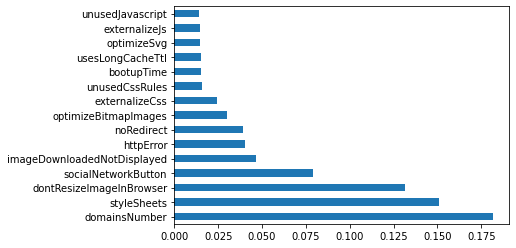

In [119]:
# Model Feature Importance

pd.Series(importances_nbRequest, index=X_dev.columns).nlargest(15).plot(kind='barh') 

In [120]:
importances_nbRequest = get_feature_importance(importances_nbRequest, X_train)
importances_nbRequest

['domainsNumber',
 'styleSheets',
 'dontResizeImageInBrowser',
 'socialNetworkButton',
 'imageDownloadedNotDisplayed',
 'httpError',
 'noRedirect',
 'optimizeBitmapImages',
 'externalizeCss',
 'unusedCssRules',
 'bootupTime',
 'usesLongCacheTtl',
 'optimizeSvg',
 'externalizeJs',
 'unusedJavascript',
 'addExpiresOrCacheControlHeaders',
 'jsValidate',
 'usesHttp2',
 'mainthreadWorkBreakdown',
 'compressHttp',
 'modernImageFormats']

Permutation explainer: 112it [01:03,  1.47it/s]


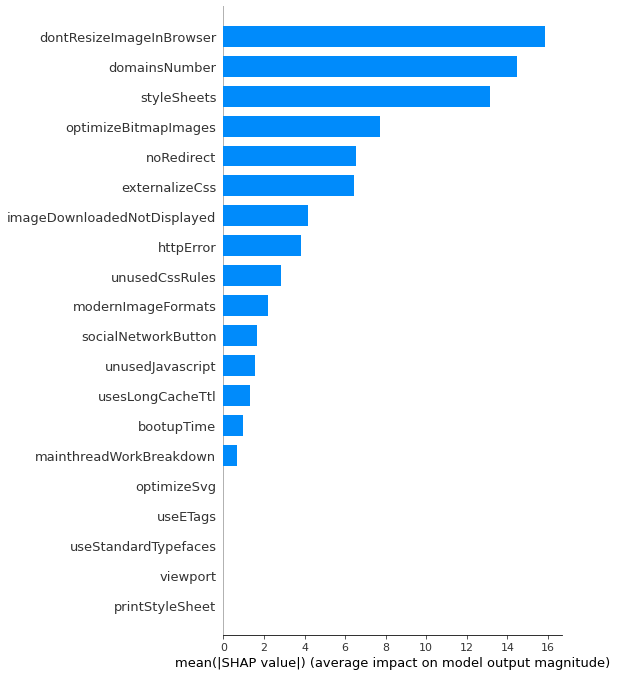

In [121]:
## SHAP feature Importance

explainer = shap.Explainer(rfe.predict, X_test)

shap_values = explainer(X_test)

shap.summary_plot(shap_values, features=X, feature_names=X.columns, plot_type='bar')

### XG boost

In [122]:

start_time = time.time()

params = {'min_samples_split' : [2,10,50],
          'learning_rate' : [0.1,0.002],
          'n_estimators' : [20, 40, 70]}

gs2 = GridSearchCV(GradientBoostingRegressor(), params, cv = 5)

gs2.fit(X_dev, y_dev)

print("Time: {} seconds".format(time.time() - start_time))

print("best parameters are", gs2.best_params_)

print("model performance on test dataset", gs2.score(X_test, y_test))

y_pred = gs2.predict(X_test)



print("results before feature selection:")
print(f'model score on training data : {gs2.score(X_dev,  y_dev)}')
print(f'model score on testing data: {gs2.score(X_test, y_test)}')

importances_nbRequest = gs2.best_estimator_.feature_importances_




Time: 5.88013768196106 seconds
best parameters are {'learning_rate': 0.1, 'min_samples_split': 10, 'n_estimators': 40}
model performance on test dataset 0.5383995575945679
results before feature selection:
model score on training data : 0.8200734570068131
model score on testing data: 0.5383995575945679


In [123]:
importances_nbRequest = get_feature_importance(importances_nbRequest, X_train)
importances_nbRequest

['styleSheets',
 'domainsNumber',
 'dontResizeImageInBrowser',
 'socialNetworkButton',
 'imageDownloadedNotDisplayed',
 'noRedirect',
 'optimizeBitmapImages',
 'httpError',
 'externalizeCss',
 'externalizeJs',
 'unusedCssRules',
 'useStandardTypefaces',
 'optimizeSvg']

In [124]:
explainer = shap.Explainer(gs2.predict, X_test)

shap_values = explainer(X_test)

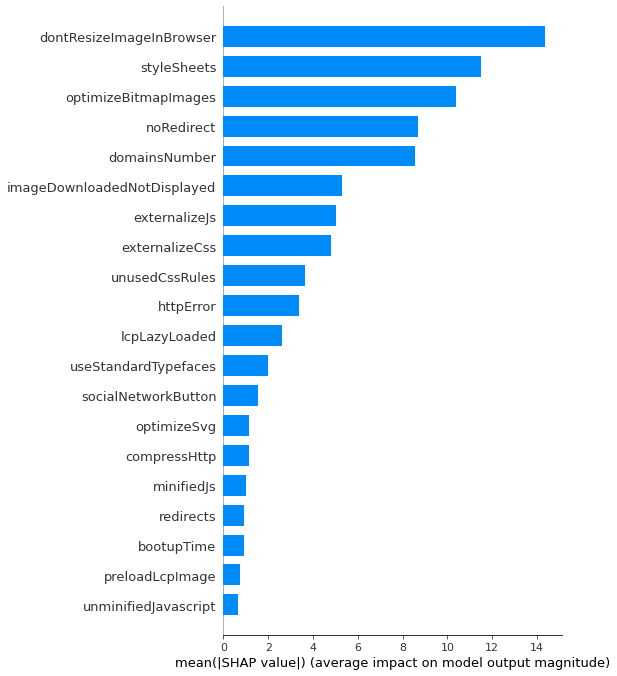

In [125]:
shap.summary_plot(shap_values, features=X, feature_names=X.columns, plot_type='bar')

## DomSize

In [126]:
X = df.drop(columns = ["ecoIndex", 'nbRequest',	'responsesSize','domSize', 'httpRequests', 'urlName'])
y = df["domSize"]


# split the data into developing and testing sets
X_dev,X_test,y_dev,y_test = train_test_split(X,y,test_size=0.2,random_state=42)


### Random Forest

In [127]:
start_time = time.time()

params = {'n_estimators' : [10,50, 100, 200],
          'max_depth' : [10, 20, 40,50]}


rf = RandomForestRegressor(random_state=42)

gs1 = GridSearchCV(rf, params, cv = 10)

gs1.fit(X_dev, y_dev)


print("Time: {} seconds".format(time.time() - start_time))

y_pred = gs1.predict(X_test)

print ('Best Parameters: ', gs1.best_params_, ' \n')

print("results before feature selectio:")
print(f'model score on training data : {gs1.score(X_dev,  y_dev)}')
print(f'model score on testing data: {gs1.score(X_test, y_test)}')

importances_DomSize = gs1.best_estimator_.feature_importances_


best_model = RandomForestRegressor(**gs1.best_params_)


rfe = RFE(best_model, n_features_to_select=15)

# Fit the model to the data
rfe.fit(X_train, y_train)

print("results after feature selection:")

print(f'model score on training data : {rfe.score(X_dev,  y_dev)}')
print(f'model score on testing data: {rfe.score(X_test, y_test)}')

# Print the selected features
selected_features = list(X.columns[rfe.support_])
print(selected_features)

model_Domsize = rfe

Time: 55.882219314575195 seconds
Best Parameters:  {'max_depth': 20, 'n_estimators': 100}  

results before feature selectio:
model score on training data : 0.9352256642128197
model score on testing data: 0.5644781750549899
results after feature selection:
model score on training data : -0.45254620632643716
model score on testing data: -0.5064083635328143
['addExpiresOrCacheControlHeaders', 'domainsNumber', 'dontResizeImageInBrowser', 'externalizeCss', 'externalizeJs', 'imageDownloadedNotDisplayed', 'noRedirect', 'styleSheets', 'useStandardTypefaces', 'mainthreadWorkBreakdown', 'bootupTime', 'usesLongCacheTtl', 'unusedCssRules', 'unusedJavascript', 'modernImageFormats']


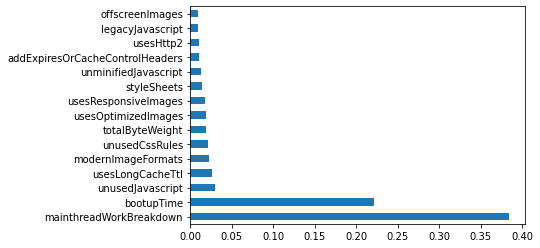

In [128]:
## Model Feature Importance

pd.Series(importances_DomSize, index=X.columns).nlargest(15).plot(kind='barh') 

In [129]:
importances_DomSize = get_feature_importance(importances_DomSize, X_train)


Permutation explainer: 112it [00:33,  2.34it/s]


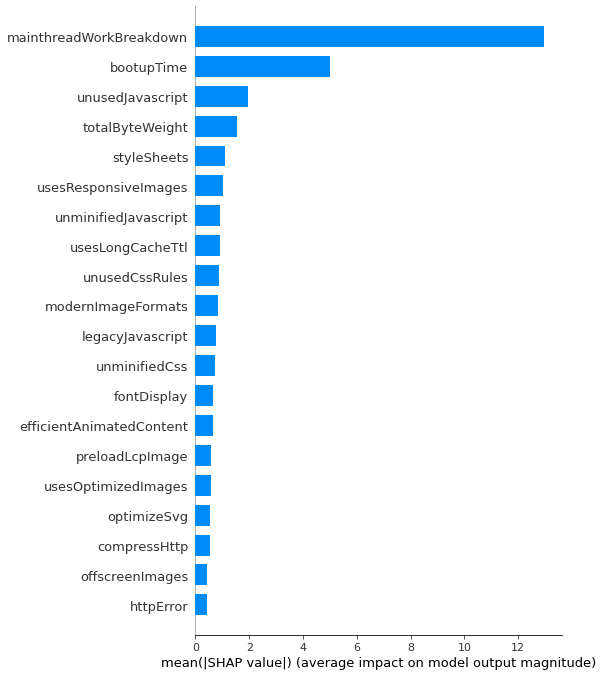

In [130]:
## SHAP EXPLAINER

explainer = shap.Explainer(gs1.predict, X_test)

shap_values = explainer(X_test)

shap.summary_plot(shap_values, features=X, feature_names=X.columns, plot_type='bar')

### XGB

In [131]:

start_time = time.time()

params = {'min_samples_split' : [2,10,50],
          'learning_rate' : [0.1,0.002],
          'n_estimators' : [20, 40, 70]}

gs2 = GridSearchCV(GradientBoostingRegressor(), params, cv = 10)

gs2.fit(X_dev, y_dev)

print("Time: {} seconds".format(time.time() - start_time))

print("best parameters are", gs2.best_params_)

print("model performance on test dataset", gs2.score(X_test, y_test))

y_pred = gs2.predict(X_test)



print("results before feature selectio:")
print(f'model score on training data : {gs2.score(X_dev,  y_dev)}')
print(f'model score on testing data: {gs2.score(X_test, y_test)}')

importances_DomSize = gs2.best_estimator_.feature_importances_


Time: 12.255551099777222 seconds
best parameters are {'learning_rate': 0.1, 'min_samples_split': 2, 'n_estimators': 20}
model performance on test dataset 0.5402198017012773
results before feature selectio:
model score on training data : 0.680357609929441
model score on testing data: 0.5402198017012773


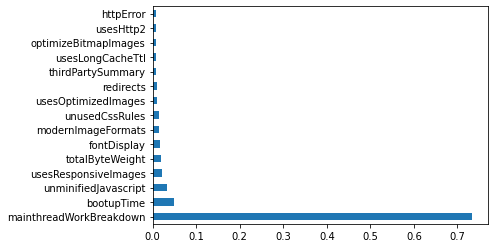

In [132]:
## Model Feature Importance

pd.Series(importances_DomSize, index=X.columns).nlargest(15).plot(kind='barh') 

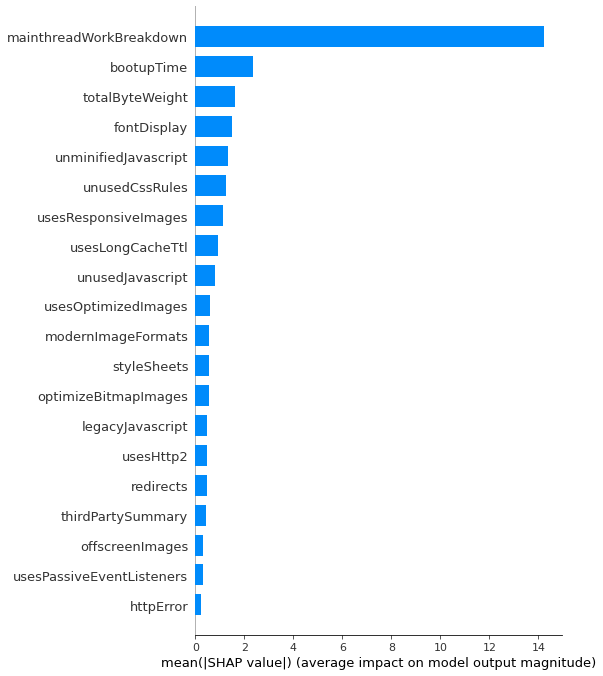

In [133]:
## SHAP EXPLAINER

explainer = shap.Explainer(gs2.predict, X_test)

shap_values = explainer(X_test)

shap.summary_plot(shap_values, features=X, feature_names=X.columns, plot_type='bar')

## responsesSize

In [134]:
X = df.drop(columns = ["ecoIndex", 'nbRequest',	'responsesSize','domSize', 'httpRequests', 'urlName'])
y = df["responsesSize"]


# split the data into developing and testing sets
X_dev,X_test,y_dev,y_test = train_test_split(X,y,test_size=0.2,random_state=42)



### Random Forest

In [135]:
start_time = time.time()

params = {'n_estimators' : [10,50, 100, 200],
          'max_depth' : [10, 20, 40,50]}


rf = RandomForestRegressor(random_state=42)

gs1 = GridSearchCV(rf, params, cv = 10)

gs1.fit(X_train, y_train)


print("Time: {} seconds".format(time.time() - start_time))

y_pred = gs1.predict(X_test)

print ('Best Parameters: ', gs1.best_params_, ' \n')

print("results before feature selection:")
print(f'model score on training data : {gs1.score(X_dev,  y_dev)}')
print(f'model score on testing data: {gs1.score(X_test, y_test)}')

importances_ResponseSize = gs1.best_estimator_.feature_importances_


Time: 55.069865703582764 seconds
Best Parameters:  {'max_depth': 40, 'n_estimators': 100}  

results before feature selection:
model score on training data : -0.3832312811815024
model score on testing data: -0.4963938536559145


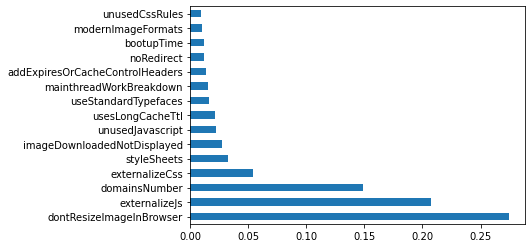

In [136]:
## Model Feature Importance

pd.Series(importances_ResponseSize, index=X.columns).nlargest(15).plot(kind='barh') 

### XGB

In [138]:

start_time = time.time()

params = {'min_samples_split' : [2,10,50],
          'learning_rate' : [0.1,0.003],
          'n_estimators' : [20, 40, 70]}

gs2 = GridSearchCV(GradientBoostingRegressor(), params, cv = 5)

gs2.fit(X_dev, y_dev)

print("Time: {} seconds".format(time.time() - start_time))

print("best parameters are", gs2.best_params_)

print("model performance on test dataset", gs2.score(X_test, y_test))

y_pred = gs2.predict(X_test)



print("results before feature selectio:")
print(f'model score on training data : {gs2.score(X_dev,  y_dev)}')
print(f'model score on testing data: {gs2.score(X_test, y_test)}')

importances_responseSize = gs2.best_estimator_.feature_importances_


Time: 5.89905309677124 seconds
best parameters are {'learning_rate': 0.1, 'min_samples_split': 50, 'n_estimators': 20}
model performance on test dataset 0.045207592726429824
results before feature selectio:
model score on training data : 0.5234960382092637
model score on testing data: 0.045207592726429824


## Recommendation

In [145]:
### The final recommendations are ordered by order of difficulty of implementation

Nb_final_feat = ['dontResizeImageInBrowser','socialNetworkButton','noRedirect','httpError','useStandardTypefaces','imageDownloadedNotDisplayed','styleSheets',]

DomSize_final_feat = ['bootupTime', 'styleSheets', "mainthreadWorkBreakdown"]

best_rec = ['dontResizeImageInBrowser','externalizeJs','domainsNumber','externalizeCss','styleSheets','imageDownloadedNotDisplayed',]

In [141]:
easy_list= ["images resized in browser number", "empty src tag number", "images downloazded not displayed number", "total min gains", "total size to optimize", "viewport", "fontDisplay","usesResponsiveImages", "unusedCssRules","unusedJavscript","usesOptimizedImages","modernImageFormats","efficientAnimatedContent", "noDocumentWrite"]

medium_list= ["cache header ratio","compress ratio","inline style sheets number","inline js scripts number", "error number","js validate", "percent minified css","percent minified js","redirect number", "plugins number","print style sheets number","number social network button","style sheets number", "eTags Ratio","total Fonts Size","bootupTime","thirdPartySummary","lcpLazyLoaded","domSize","offscreenImages", "usesTextCompression","usesHttp2","legacyJavascript","usesPassiveEventListeners"]

hard_list= ["domains number","number of requests","max cookies length","total cookies size","serverResponsetime", "mainthreadWorkBreakdown","usesLongCacheTtl","totalByteWeight"] 

In [142]:
def get_index_of_row(df, value, column):
  return df[df[column] == value].index[0]


In [146]:
def give_me_reco(url,df):

    index = get_index_of_row(df, url, "urlName")

    nbReq = df.at[index, 'nbRequest']
    domSize = df.at[index, 'domSize']
    features=  df.iloc[index:index+1,6:63]
    
    reco = []


    ##Append the overall best recommendations:

    for n in best_rec:

      value = df.at[index, n]
    
      if value < 50: 
          reco.append(n)


    ## Append the DomSize recommendations 

    for n in DomSize_final_feat:

      value = df.at[index, n]
    
      if value < 50: 
          reco.append(n)


    ##Append The nb Recommendations

    
    for n in Nb_final_feat:

        value = df.at[index, n]
    
        if value < 40: 
            reco.append(n)

  
    
    return np.unique(reco)


In [147]:
reco = give_me_reco('https://www.amazon.com/',df)

reco

['domainsNumber', 'mainthreadWorkBreakdown', 'dontResizeImageInBrowser']

# Recommendations Applications

In [ ]:
## Here, we only modify the top three feature importance from the EcoIndex XGboost model to observe the impact

In [155]:
y = pd.DataFrame(y_test_ecoIndex)
df_analysis = pd.concat([X_dev_ecoIndex,y], axis = 1)

#model_EcoIndex

df_old = X_test
df_new = df_analysis.drop(columns = ['ecoIndex'])

In [156]:
 for index, row in df_analysis.iterrows():

      grade = row['ecoIndex']

      if grade < 50 :
  
        if df_new.at[index, 'dontResizeImageInBrowser'] < 50:
        
            df_new.at[index, 'dontResizeImageInBrowser'] = 100

        if df_new.at[index, 'externalizeJs'] < 50:
        
            df_new.at[index, 'externalizeJs'] = 100

        if df_new.at[index, 'styleSheets'] < 50:
        
            df_new.at[index, 'styleSheets'] = 100

### Predict the New EcoIndex with the Regressor EcoIndex

In [157]:

model_EcoIndex = final_model
# predict the Eco-Index

#old
pred_old = model_EcoIndex.predict(df_old)
#plot the distribution of EcoIndex

#new
pred_new = model_EcoIndex.predict(df_new)
#plot the distribution of Grades



In [158]:
d = {'Old EcoIndex': pred_old, "Current EcoIndex": pred_new}
dataset  = pd.DataFrame(d)
dataset

,Old EcoIndex,Current EcoIndex
0,25.197543,50.211649
1,32.299114,59.416867
2,40.066203,53.921224
3,56.838558,56.838558
4,59.127683,71.539946
...,...,...
106,35.797553,35.797553
107,43.401747,66.168810
108,84.813650,84.813650
109,63.192608,63.192608


Text(0.5, 0, 'EcoIndex')

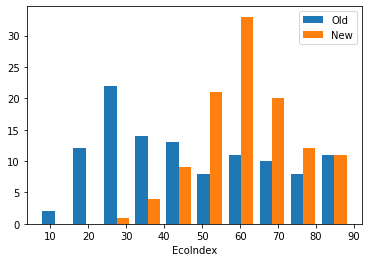

In [159]:
%matplotlib inline
plt.hist([pred_old, pred_new], label=['Old', 'New'])
plt.legend()

plt.xlabel('EcoIndex')


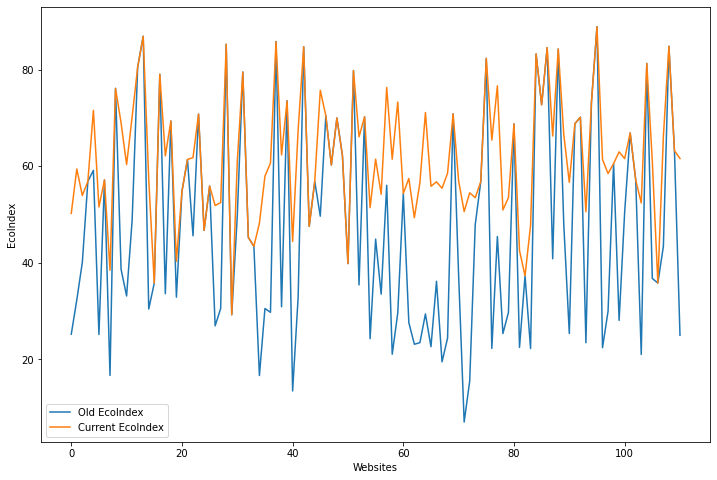

In [160]:
plt.figure(figsize=(12,8)) 
y = [i for i in range(len(df_old))]


plt.plot(y, pred_old, label = "Old EcoIndex")
plt.plot(y, pred_new, label = "Current EcoIndex")

plt.ylabel('EcoIndex')
plt.xlabel('Websites')

plt.legend()
plt.show()